# Alternative respiration methods


In [1]:
# add root directory to python path
import sys, os
if os.path.join(sys.path[0], '..') not in sys.path:
    sys.path.insert(1, os.path.join(sys.path[0], '..'))

# perform imports
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from sweeprecon.io.ImageData import ImageData

from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats import wasserstein_distance


(400, 162, 672)
rect not defined defaulting to full FOV
(400, 162, 152)


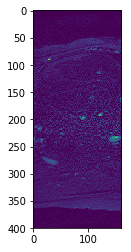

In [2]:
# load image data and crop slices to reduce processing time
image_path = 'data/IMG_3D_cropped_steady.nii.gz'

Image = ImageData(image_path)
print(Image.img.shape)

Image.square_crop(crop_z=[200,350])

# Check shape
print(Image.img.shape)
plt.imshow(Image.img[:,:,1])

In [ ]:
Image.img.shape

In [ ]:
from skimage.feature import register_translation
from scipy import signal

#from skimage.metrics import structural_similarity as ssim
from skimage.measure import compare_ssim

# one off test no loops
img_resp = Image.img[50:100,50:100,:]  # anterior patch with resp
img_static = Image.img[300:350,0:50,:]  # patch with no resp

plt.imshow(Image.img[:,:,1])

test = 50
kern = 25

error = np.zeros(len(np.arange(test-kern,test+kern)))
diffphase = np.zeros(len(np.arange(test-kern,test+kern)))

ssim_resp = np.zeros(len(np.arange(test-kern,test+kern)))
ssim_static = np.zeros(len(np.arange(test-kern,test+kern)))

ssd_resp = np.zeros(len(np.arange(test-kern,test+kern)))
ssd_static = np.zeros(len(np.arange(test-kern,test+kern)))

nmi_resp = np.zeros(len(np.arange(test-kern,test+kern)))
nmi_static = np.zeros(len(np.arange(test-kern,test+kern)))

cc_resp = np.zeros(len(np.arange(test-kern,test+kern)))
cc_static = np.zeros(len(np.arange(test-kern,test+kern)))


def sumsd(img1, img2):
    return np.sum((img1 - img2) ** 2)

def nmi(img1, img2, bins=128):
    hist_2d, x_edges, y_edges = np.histogram2d(img1.ravel(),img2.ravel(),bins=bins)
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def normcrosscor(img1, img2):
    # implement from wiki cross correlation
    sigm1 = np.std(img1)
    sigm2 = np.std(img2)
    npix = img1.size
    return (1/npix) * np.sum( (1/(sigm1*sigm2)) * img1 * img2)

def znormcrosscor(img1, img2):
    # implement from wiki cross correlation
    sigm1 = np.std(img1)
    sigm2 = np.std(img2)
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    npix = img1.size
    return (1/npix) * np.sum( (1/(sigm1*sigm2)) * (img1-mu1) * (img2-mu2))
    
    
for nn, zz in enumerate(range(test - kern, test+kern)):
    #shift, error[nn], diffphase[nn] = register_translation(img[:,:,test], img[:,:,zz])
    #cc[:,:,nn] = signal.correlate2d(img[:,:,test], img[:,:,zz])
    ssim_resp[nn] = compare_ssim(img_resp[:,:,zz], img_resp[:,:,test], gaussian_weights=True, sigma=3)
    ssim_static[nn] = compare_ssim(img_static[:,:,zz], img_static[:,:,test], gaussian_weights=True, sigma=3)
    
    ssd_resp[nn] = sumsd(img_resp[:,:,zz], img_resp[:,:,test])
    ssd_static[nn] = sumsd(img_static[:,:,zz], img_static[:,:,test])
    
    nmi_resp[nn] = nmi(img_resp[:,:,zz], img_resp[:,:,test])
    nmi_static[nn] = nmi(img_static[:,:,zz], img_static[:,:,test])
    
    cc_resp[nn] = znormcrosscor(img_resp[:,:,zz], img_resp[:,:,test])
    cc_static[nn] = znormcrosscor(img_static[:,:,zz], img_static[:,:,test])

In [ ]:
import statsmodels.api as sm
from scipy.signal import medfilt

from math import ceil

def lowess_sm(x, y, filt_dist_mm=5, iter=5):
    lowess = sm.nonparametric.lowess
    kern = ceil(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern_frac = kern / len(y)
    x = np.arange(0, y.shape[0])
    yest = lowess(y, x, frac=kern_frac, it=iter)
    return yest[:,1]

def medfilt_dist(x, y, filt_dist_mm=5,):
    kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern = int(np.ceil(kern) // 2 * 2 + 1)  # round up to nearest odd n
    print(kern)
    return medfilt(y, kernel_size=kern)


In [ ]:

import scipy.stats as stats

x = np.linspace(0, 2*kern, 2*kern)

def gausswindow(x, mu):
    window = stats.norm.pdf(x, mu, mu/3)
    return ((window - np.min(window)) / (np.max(window) - np.min(window)))
    
def linwindow(x,mu):
    # linear ramp up down - doesnt work atm come back to this probably not usefuls
    return np.concat(np.linspace(0,1,mu), np.linspace(1,0,mu))
    
window = gausswindow(x, kern)
plt.plot(x,window)

In [ ]:
# delete refernce slice
fig, ax = plt.subplots(3, 2, sharex='col', figsize=(15, 10))
filt_dist_mm=8

ax[0,0].set_title('resp sim measures')
ax[0,0].plot(nmi_resp,'g.-')
ax[0,0].plot(ssim_resp,'b.-')
ax[0,0].plot(cc_resp,'r.-')
#ax[0,0].set_ylim([-0.1, 0.8])

ax[0,1].set_title('static sim measures')
ax[0,1].plot(nmi_static,'g.-')
ax[0,1].plot(ssim_static,'b.-')
ax[0,1].plot(cc_static,'r.-')
#ax[0,1].set_ylim([0, 1.0])

ax[1,0].set_title('resp sim measures - windowed')
#ax[1,0].plot(nmi_resp*window,'g.-')
#ax[1,0].plot(ssim_resp*window,'b.-')
ax[1,0].plot((cc_resp*window),'r.-')
ax[1,0].plot(medfilt_dist(x, cc_resp*window, filt_dist_mm=filt_dist_mm))
ax[1,0].set_ylim([0, 1.2])

ax[1,1].set_title('static sim measures - windowed')
#ax[1,1].plot(ssim_static*window,'b.-')
ax[1,1].plot(cc_static*window,'r.-')
ax[1,1].plot(medfilt_dist(x, cc_static*window, filt_dist_mm=filt_dist_mm))
ax[1,1].set_ylim([0, 1.2])

local_sim_resp = (cc_resp*window) - medfilt_dist(x, cc_resp*window, filt_dist_mm=filt_dist_mm)
local_sim_static = (cc_static*window) - medfilt_dist(x, cc_static*window, filt_dist_mm=filt_dist_mm)

ax[2,0].plot(local_sim_resp,'k.-')
ax[2,0].set_title('local sim resp')

ax[2,1].plot(local_sim_static,'k.-')
ax[2,1].set_title('local sim static')

___
Test on full volume

In [5]:
# Formalise for volume
import time
import copy
from scipy.signal import medfilt, medfilt2d
import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter
from skimage.exposure import equalize_adapthist
import statsmodels.api as sm

class local_sim(object):
    
    def __init__(self, Image, local_patch_size, windowed=True, filter=True):
        self.Image = Image
        self.img = copy.deepcopy(Image.img)
        self.sim_img = np.zeros((Image.img.shape[0], Image.img.shape[1],Image.img.shape[2], Image.img.shape[2]), dtype=np.float32)
        self.local_patch_size = local_patch_size
        self.img_local = np.zeros((local_patch_size[0], local_patch_size[1],Image.img.shape[2]))
        self.window = np.ones((local_patch_size[2],), dtype=int)
        self.sim_matrix = np.zeros((local_patch_size[2], local_patch_size[2],))
        self.kern = int(self.local_patch_size[0]/2)
        self.cc_resp = np.zeros(self.local_patch_size[2])
        if windowed:
            self.gauss_window()
            plt.plot(self.window)
            plt.title('local window')
            plt.show()
        print(self.sim_img.shape)
        if filter:
            print('Filtering input')
            for zz in range(0, self.img.shape[2]):
                #self.img[:,:,zz] = equalize_adapthist(self.img[:,:,zz].astype('uint16'), clip_limit=0.05)
                #self.img[:,:,zz] = gaussian_filter(self.img[:,:,zz], 1.0)
                self.img[:,:,zz] = medfilt2d(self.img[:,:,zz], kernel_size=5)
                
    def extract_local_patch(self,xx,yy):
        xs = np.arange(xx - self.local_patch_size[0]/2, xx + self.local_patch_size[0]/2).astype(int)
        ys = np.arange(yy - self.local_patch_size[1]/2, yy + self.local_patch_size[1]/2).astype(int)
        self.img_local[:,:,:] = self.img[xs, ys, :]
        
    def local_sim(self, xx, yy):
        # loop over target slices
        for tt in range(0, self.img_local.shape[2]-1):
            # loop over test slices
            _offset1 = 0
            _offset2 = self.local_patch_size[2]
            for nn, zz in enumerate(range(tt - int(self.local_patch_size[2]/2), tt + int(self.local_patch_size[2]/2))):
                if (zz < 0):
                    self.cc_resp[nn] = 0
                    _offset1 += 1
                elif (zz > self.sim_img.shape[2]-1):
                    self.cc_resp[nn] = 0   
                    _offset2 += -1
                else:
                    self.cc_resp[nn] = self.sumsd(self.img_local[:,:,zz], self.img_local[:,:,tt])
            
            #sim_v = (self.cc_resp - self.lowess_sm(range(0,len(self.cc_resp)), self.cc_resp)) * self.window
            sim_v = (self.cc_resp)

            #sim_v = self.cc_resp - self.medfilt_dist_mm(np.linspace(0, self.local_patch_size[0], self.local_patch_size[0]), self.cc_resp)) * self.window
            
            # sim_v = self.cc_resp * self.window # - offset
            #print(sim_v.shape)
            #print(range(_offset1,_offset2))
            self.sim_img[xx,yy,tt,range( max(0, tt - int(self.local_patch_size[2]/2)), min(tt + int(self.local_patch_size[2]/2), self.sim_img.shape[2]))] = sim_v[range(_offset1,_offset2),]  #.clip(min=0)  # set negative values to 0
    
    def second_diff(self, v):
        return np.gradient(np.gradient(v))
    
    def gauss_window(self, std_mm=2, notch=False):
        std = std_mm / self.Image.nii.header["pixdim"][3]
        x = np.linspace(0, self.local_patch_size[2], self.local_patch_size[2])
        window = stats.norm.pdf(x, self.local_patch_size[2]/2, std)
        self.window = ((window - np.min(window)) / (np.max(window) - np.min(window)))
        if notch:
            self.window = 0.1 + np.ones(window.shape) - ((window - np.min(window)) / (np.max(window) - np.min(window)))  
        
    def sumsd(self, img1, img2):
        return np.sum((img1.ravel() - img2.ravel()) ** 2)
    
    def absdiff(self, img1, img2):
        return np.sum(np.abs(img1.ravel() - img2.ravel()))
    
    def znormcrosscor(self, img1, img2):
        # implement from wiki cross correlation
        return (1/img1.size) * np.sum( (1/(np.std(img1)*np.std(img2))) * (img1-np.mean(img1)) * (img2-np.mean(img2)))    
    
    def crosscor(self, img1, img2):
        # implement from wiki cross correlation
        return (1/img1.size) * np.sum( (1/(np.std(img1)*np.std(img2))) * (img1) * (img2))   
    
    def nmi(self, img1, img2, bins=20):
        hist_2d, x_edges, y_edges = np.histogram2d(img1.ravel(),img2.ravel(),bins=bins)
        pxy = hist_2d / float(np.sum(hist_2d))
        px = np.sum(pxy, axis=1) # marginal for x over y
        py = np.sum(pxy, axis=0) # marginal for y over x
        px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
        # Now we can do the calculation using the pxy, px_py 2D arrays
        nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
        return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    def medfilt_dist_mm(self, x, y, filt_dist_mm=5,):
        kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
        kern = int(np.ceil(kern) // 2 * 2 + 1)  # round up to nearest odd n
        return medfilt(y, kernel_size=kern)
    
    def lowess_sm(self, x, y, filt_dist_mm=4, iter=5):
        kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
        kern_frac = kern / len(y)
        x = np.arange(0, y.shape[0])
        yest = sm.nonparametric.lowess(y, x, frac=kern_frac, it=iter)
        return yest[:,1]
    
    def optimal_slices(self, sample_density=0.02):
        nsx = sample_density * self.img.shape[0]
        nsy = sample_density * self.img.shape[1]
        
        self.sx = np.linspace(int(self.local_patch_size[0]/2), self.img.shape[0] - int(self.local_patch_size[0]/2), nsx).astype(int)
        self.sy = np.linspace(int(self.local_patch_size[1]/2), self.img.shape[1] - int(self.local_patch_size[1]/2), nsy).astype(int)
        
        print('calculating sim measure for %d patches' % (len(self.sx) * len(self.sy)))
        for xx in self.sx:
            for yy in self.sy:
                print((xx,yy))
                self.extract_local_patch(xx,yy)
                self.local_sim(xx,yy)
        
        # for each x(sample_density)
        # for each y(sample_density)
        # extract local region
        # for ecah t(all)
        # define local sim and store
        
        # interpolate slice density
        # find optimal interpolation weights for coherent volume
        
        return

clearing old localsim


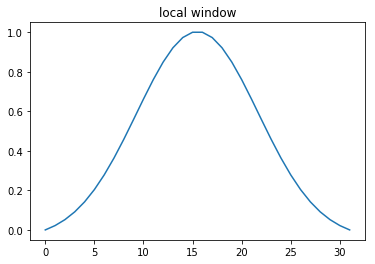

(400, 162, 152, 152)
Filtering input
calculating sim measure for 24 patches
(43, 43)
(43, 81)
(43, 119)
(87, 43)
(87, 81)
(87, 119)
(132, 43)
(132, 81)
(132, 119)
(177, 43)
(177, 81)
(177, 119)
(222, 43)
(222, 81)
(222, 119)
(267, 43)
(267, 81)
(267, 119)
(312, 43)
(312, 81)
(312, 119)
(357, 43)
(357, 81)
(357, 119)


In [6]:
#del localsim
import gc

if 'localsim' in locals():
    print('clearing old localsim')
    del localsim

gc.collect() 

local_def = (86,86,32)
localsim = local_sim(Image, local_def)
slices = localsim.optimal_slices()

range(86, 118)
(32,)


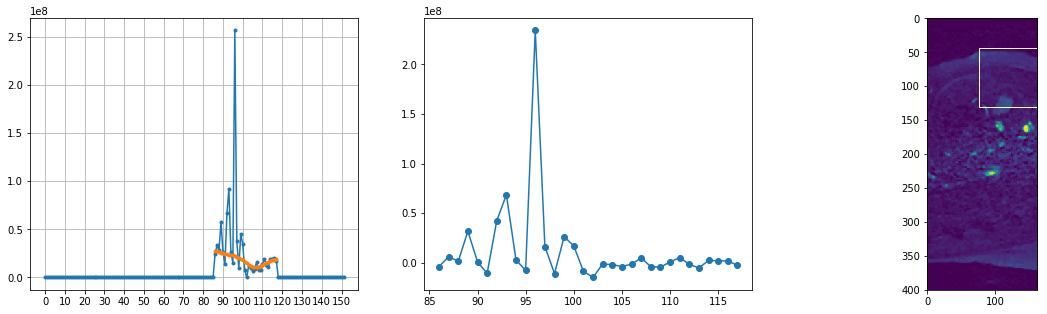

In [17]:
# test 
import matplotlib.patches as patches
import statsmodels.api as sm

def lowess_sm(x, y, filt_dist_mm=5, iter=5):
    #lowess = sm.nonparametric.lowess
    kern = int(filt_dist_mm / Image.nii.header["pixdim"][3])
    kern_frac = kern / len(y)
    x = np.arange(0, y.shape[0])
    yest = sm.nonparametric.lowess(y, x, frac=kern_frac, it=iter)
    return yest[:,1]

def gauss_window(local_patch_size, Image, std_mm=1.0, notch=False):
        std = std_mm / Image.nii.header["pixdim"][3]
        x = np.linspace(0, local_patch_size[2], local_patch_size[2])
        window = stats.norm.pdf(x, local_patch_size[2]/2, std)
        window = ((window - np.min(window)) / (np.max(window) - np.min(window)))
        if notch:
            window = 0.1 + np.ones(window.shape) - ((window - np.min(window)) / (np.max(window) - np.min(window)))
        return window

#test_patch = (357, 119, 20)  # static#
test_patch = (87, 119, 102)  # resp

fig, ax = plt.subplots(1, 3, sharex='col', figsize=(20, 5))

x_local = range( max(0, test_patch[2]-int(local_def[2]/2)), min(localsim.sim_img.shape[2], test_patch[2]+int(local_def[2]/2)) )

print(x_local)

vv = np.squeeze(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:])

print(vv[x_local].shape)

ax[0].plot(vv, '.-')
ax[0].plot(x_local, lowess_sm(x_local, vv[x_local]), '.-')

#ax[0].plot(vv - medfilt_dist_mm(np.linspace(0, local_def[0], local_def[0]), vv), '.-')
#ax[0].plot(np.squeeze(localsim.sim_img[test_patch_stat[0],test_patch_stat[1],test_patch_stat[2],:]), '.-')

ax[1].plot(x_local, vv[x_local] - lowess_sm(x_local, vv[x_local]), 'o-')

ax[2].imshow(localsim.img[:, :, test_patch[2]])
rect1 = patches.Rectangle((test_patch[1]-(local_def[1]/2),test_patch[0]-(local_def[0]/2)),local_def[1],local_def[0],linewidth=1,edgecolor='w',facecolor='none')
ax[2].add_patch(rect1)
#rect2 = patches.Rectangle((test_patch_stat[1]-(local_def[1]/2),test_patch_stat[0]-(local_def[0]/2)),local_def[1],local_def[0],linewidth=1,edgecolor='r',facecolor='none')
#ax[2].add_patch(rect2)

ax[0].grid()
ax[0].set_xticks(np.arange(0,Image.img.shape[2]+1,10))
#ax[0].plot(0.8+-1*np.gradient( np.gradient(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:],)),'.-')

[16 19 22 23 15 20 12 18 27 17 26 24  5  9 21 31 25 28 29 30  0  8  4  2
  1 14 11 13  3  6  7 10]


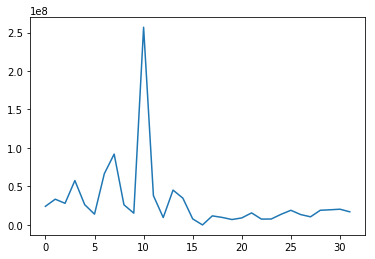

In [18]:
X = np.linspace(0, local_def[2], local_def[2]).astype(int)

#Y = (vv[x_local] - lowess_sm(x_local, vv[x_local])) * window
Y = vv[x_local] 

plt.plot(Y)
#Y = np.squeeze(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:])

Z = np.argsort(Y)

ii = 0
xs = np.arange(test_patch[0] - local_def[0]/2, test_patch[0] + local_def[0]/2).astype(int)
ys = np.arange(test_patch[1] - local_def[1]/2, test_patch[1] + local_def[1]/2).astype(int)
zs = np.arange(test_patch[2] - local_def[2]/2, test_patch[2] + local_def[2]/2).astype(int)

#plt.plot(Y[Z])

print(Z)

In [9]:
ii=0

102


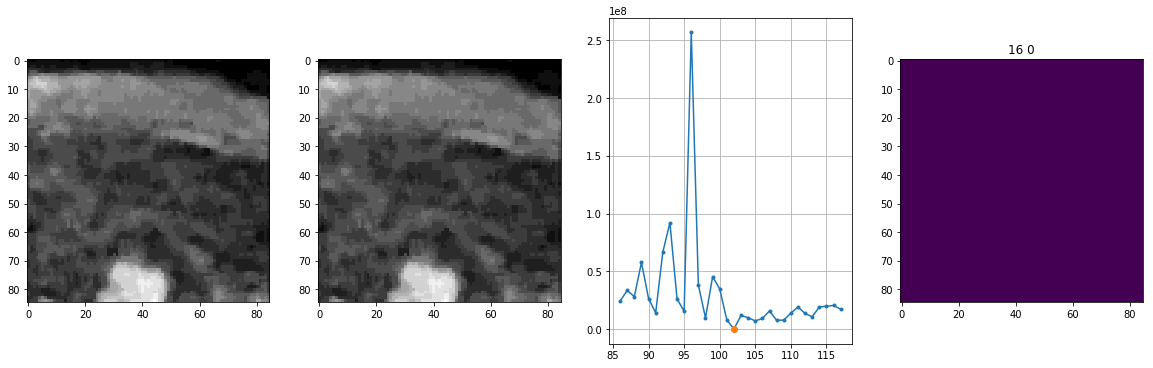

In [19]:
fig, ax = plt.subplots(1, 4, sharex='col', figsize=(20, 6))

print(test_patch[2] - int(local_def[2]/2) + Z[ii])

ax[0].imshow( localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[ii]], cmap='gray')
ax[3].imshow( localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[0]] - localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[ii]])
#plt.clim(-0.8,0.8)

x = np.arange(0, Image.img.shape[2])

ax[2].plot(x_local,Y, '.-')
#ax[2].plot(x_local,np.squeeze(localsim.sim_img[test_patch[0],test_patch[1],test_patch[2],:]), '.-')

ax[2].plot(x_local[Z[ii]],Y[Z[ii]], 'o-')

ax[2].grid()
#ax[2].set_xticks(np.arange(0,Image.img.shape[2] + 1 ,10))
ax[3].set_title(str(Z[ii])+' ' + str(ii) )

ax[1].imshow( localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[0]], cmap='gray')

ii = ii + 1

In [20]:
# save most similar slices as nifti
patchrect = np.array( [ [test_patch[1] - int(local_def[1]/2), test_patch[0] - int(local_def[0]/2)], [test_patch[1] + int(local_def[1]/2), test_patch[0] + int(local_def[0]/2)]])
print(patchrect)
name = '_'.join(map(str, test_patch)) 
print(name)

ImageCrop = copy.deepcopy(Image)
ImageCrop.square_crop(rect=patchrect)
img = Image.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[:]]
ImageCrop.set_data(img)
ImageCrop.write_nii(('sorted_slice_%s.nii.gz' % name))

ImageCrop_diff = copy.deepcopy(Image)
ImageCrop_diff.square_crop(rect=patchrect)
img_diff = np.zeros(img.shape)
for ii in range(0, local_def[2]):
    img_diff[:,:,ii] = Image.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[ii]] - Image.img[xs[0]:xs[-1], ys[0]:ys[-1], test_patch[2] - int(local_def[2]/2) + Z[0]] 

ImageCrop_diff.set_data(img_diff)
ImageCrop_diff.write_nii(('sorted_slice_%s_diff.nii.gz' % name))

[[ 76  44]
 [162 130]]
87_119_102
Saving sorted_slice_87_119_102.nii.gz
Saving sorted_slice_87_119_102_diff.nii.gz


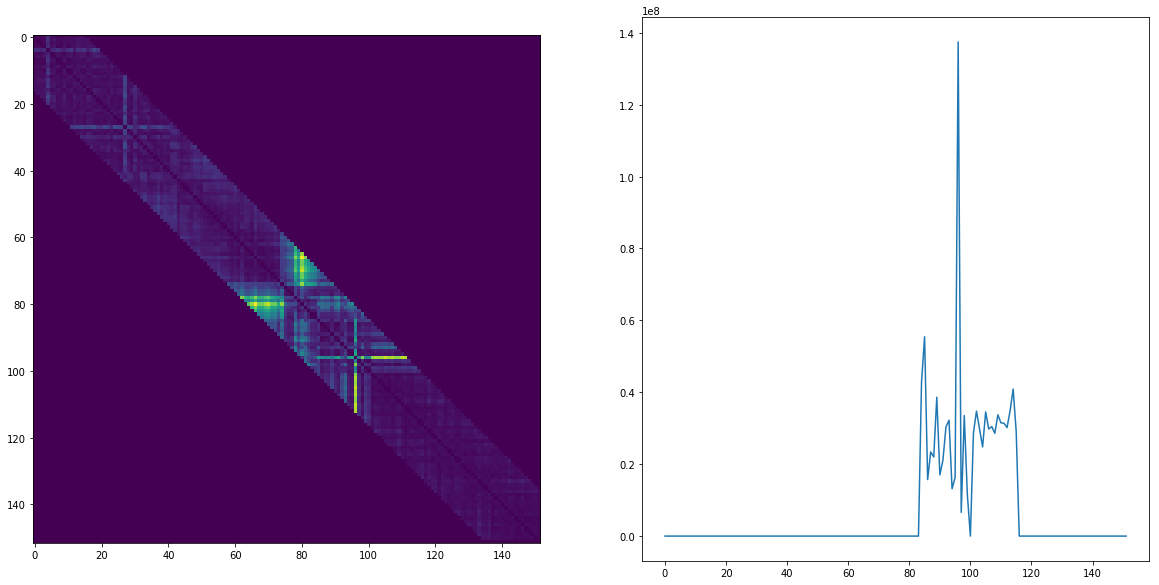

In [21]:
# visualise as slice vs slice
sim_mat1 = np.squeeze(localsim.sim_img[test_patch[0], test_patch[1],:,:])

fig, ax = plt.subplots(1, 2, sharex='col', figsize=(20, 10))

ax[0].imshow(sim_mat1)
ax[1].plot(np.squeeze(sim_mat1[100,:]))

[  8  10  11  15  19  23  34  38  45  46  50  52  53  56  57  61  65  68
  69  71  72  73  86  90  91  95 101 108 113 120 123 126 127 130 136 139
 147 148 151]
[ 11  15  19  23  34  38  45  46  50  52  53  56  57  61  65  68  69  71
  72  73  86  90  91  95 101 108 113 120 123 126 127 130 136 139 147 148
 151]


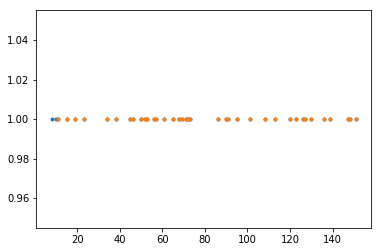

In [47]:
# Find a coherent volume
# Choose a seed slice (n) then find the most similar slice (n2) - then the most similar slice to n2 (n3) etc until n is found again. Use this subset to interpolate a volume.

seed_slice = 1
coherent_slices = np.array([])

current_slice = seed_slice

def find_slices(seed_slice, sim_mat1):
    coherent_slices = np.array([])
    current_slice = seed_slice
    while seed_slice not in coherent_slices:
        sim = np.squeeze(sim_mat1[current_slice,:])
        ax[0].plot(sim,'o-')
        slices = np.argsort(sim)
        sorted_slices = slices[sim[slices]>0]
        sorted_slices = sorted_slices[sorted_slices>current_slice] # move candidate forwards
        if not sorted_slices.size:
            break
        current_slice = sorted_slices[0]
        coherent_slices = np.append(coherent_slices, current_slice).astype(int)
    return coherent_slices

c1 = find_slices(0, sim_mat1)
c2 = find_slices(10, sim_mat1)

print(c1)
print(c2)

plt.plot(c1, np.ones(c1.shape),'.')
plt.plot(c2, np.ones(c2.shape),'.')

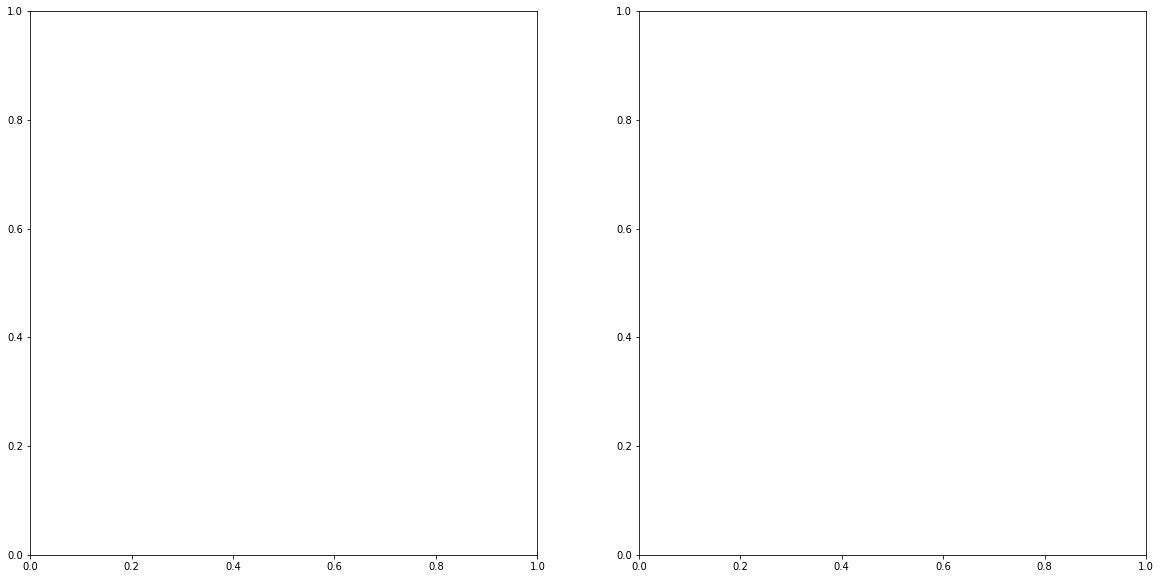

In [49]:

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = Image.img[xs[0]:xs[-1], ys[0]:ys[-1], c1]
#video = localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], np.arange(0,localsim.img[xs[0]:xs[-1], ys[0]:ys[-1], :].shape[2])]

fig, ax = plt.subplots(1, 2, sharex='col', figsize=(20, 10))

fig = plt.figure()
im = plt.imshow(video[:,:,0])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[:,:,0])

def animate(i):
    im.set_data(video[:,:,i])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[2],
                               interval=100)
HTML(anim.to_html5_video())